# Setup installs & imports

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime,timedelta
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
class Params:
    def __init__(self):
        self.years_ago = 10
        self.start_date = self.get_start_date(self.years_ago)
        self.end_date = datetime.today()
        self.risk_free_rate = .04

    def get_start_date(self, years_ago):
        return datetime.today() - timedelta(days=years_ago * 365)

class Stock_Data:
    def __init__(self, tickers):
      self.tickers = tickers

    def fetch_stock_data(self, params):
        dfs = [yf.download(ticker, start=params.start_date, end=params.end_date)[['Adj Close']].rename(columns={'Adj Close': ticker}) for ticker in self.tickers]
        adj_close_df = pd.concat(dfs, axis=1)
        adj_close_df = adj_close_df.dropna()#cleaning
        print(f"\nFetched data for {', '.join(self.tickers)} from {params.start_date} to {params.end_date}")
        return adj_close_df

class Calculation:
    def __init__(self):
       pass

    def log_returns_cal(self, adj_close_df):
        log_returns = np.log(adj_close_df/ adj_close_df.shift(1))
        return log_returns

    def cov_matrix_cal(self,log_returns):
        cov_matrix = log_returns.cov()*252 #annualized
        return cov_matrix

    def standard_deviation(self, weights, cov_matrix):
        variance = weights.T @ cov_matrix @ weights
        return np.sqrt(variance)

    def expected_return(self, weights, log_returns):
        return np.sum(log_returns.mean()*weights)*252

    def sharpe_ratio(self, weights, log_returns, cov_matrix, risk_free_rate): # sharpe ratio = (portfolio returns - risk free rate) / st.dev
        return (self.expected_return(weights, log_returns) - risk_free_rate) / self.standard_deviation(weights, cov_matrix)

    def neg_sharpe_ratio(self, weights, log_returns, cov_matrix, risk_free_rate):
        return -self.sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate) #minimize function as scipy can't detect max value, thus sharpe_ratio becomes negative

    # SLSQP Optimization
    # scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

    def SLSQP(self, constraints, bounds, initial_weights, log_returns, cov_matrix, risk_free_rate):
        optimized_results = minimize(self.neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds) #scipy.optimize.minimize() function
        return optimized_results

In [ ]:
    #Specify Tickers
    tickers = ['TSLA','ASML','BABA','JD','TLT']

    #Instances
    params = Params()
    stock_data = Stock_Data(tickers)
    calculation = Calculation()

In [ ]:
# Fetch stock data
result_df = stock_data.fetch_stock_data(params)
result_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetched data for TSLA, ASML, BABA, JD, TLT from 2014-02-05 09:06:50.813783 to 2024-02-03 09:06:50.813809


,TSLA,ASML,BABA,JD,TLT
Date,,,,,
2014-09-19,17.288000,92.050346,92.644608,27.242561,91.595215
2014-09-22,16.668667,90.425331,88.697670,25.916468,91.707138
2014-09-23,16.694000,90.014511,86.013741,25.532093,92.274574
2014-09-24,16.809334,91.475204,89.368645,26.118267,91.763115
2014-09-25,16.463333,90.544014,87.740532,25.532093,92.850067
...,...,...,...,...,...
2024-01-29,190.929993,882.619995,73.580002,23.459999,94.555771
2024-01-30,191.589996,868.030029,72.320000,22.750000,95.413010
2024-01-31,187.289993,869.820007,72.169998,22.549999,96.349998


In [ ]:
#Mean Calculation
meanReturns = result_df.mean()
meanReturns

TSLA    101.306891
ASML    324.061650
BABA    138.910539
JD       41.507621
TLT     113.829583
dtype: float64

In [ ]:
#Log returns
#Stabalise the variance data for optimisation
log_returns = calculation.log_returns_cal(result_df)
log_returns

,TSLA,ASML,BABA,JD,TLT
Date,,,,,
2014-09-19,NaN,NaN,NaN,NaN,NaN
2014-09-22,-0.036482,-0.017811,-0.043537,-0.049902,0.001221
2014-09-23,0.001519,-0.004554,-0.030727,-0.014942,0.006168
2014-09-24,0.006885,0.016097,0.038263,0.022699,-0.005558
2014-09-25,-0.020799,-0.010232,-0.018386,-0.022699,0.011776
...,...,...,...,...,...
2024-01-29,0.041055,0.016991,-0.005827,-0.016907,0.011451
2024-01-30,0.003451,-0.016668,-0.017273,-0.030732,0.009025
2024-01-31,-0.022699,0.002060,-0.002076,-0.008830,0.009772


**Calculate Covariance Matrix**





In [ ]:
#Covariance matrix
cov_matrix = calculation.cov_matrix_cal(log_returns)
cov_matrix

,TSLA,ASML,BABA,JD,TLT
TSLA,0.313278,0.082648,0.071308,0.085938,-0.005689
ASML,0.082648,0.125526,0.057687,0.066415,-0.003852
BABA,0.071308,0.057687,0.170178,0.136864,-0.004807
JD,0.085938,0.066415,0.136864,0.224373,-0.006496
TLT,-0.005689,-0.003852,-0.004807,-0.006496,0.023545


SLSQP Optimisation

In [ ]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1} #weights = 1
bounds = [(0.1, 0.3) for _ in range(len(stock_data.tickers))] #lower bound and upper bound for weightage of securities
initial_weights = np.array([1/len(stock_data.tickers)]*len(stock_data.tickers)) #equal weights

#constraints, bounds, initial_weights, log_returns, cov_matrix, risk_free_rate
optimized_results = calculation.SLSQP(constraints, bounds, initial_weights, log_returns, cov_matrix, params.risk_free_rate)

In [ ]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(stock_data.tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = calculation.expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = calculation.standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = calculation.sharpe_ratio(optimal_weights, log_returns, cov_matrix, params.risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
TSLA: 0.3000
ASML: 0.3000
BABA: 0.1000
JD: 0.1000
TLT: 0.2000
Expected Annual Return: 0.1452
Expected Volatility: 0.2780
Sharpe Ratio: 0.3783


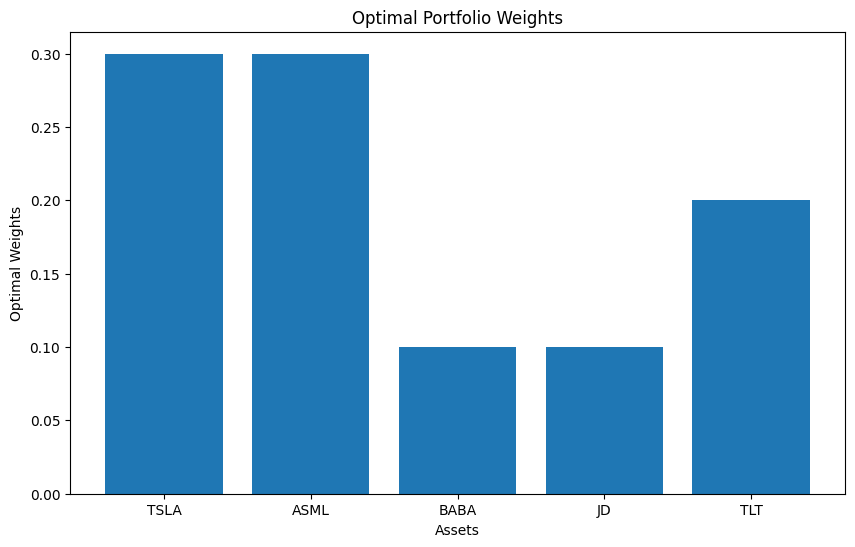

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(stock_data.tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

Monte Carlo Simulation

In [ ]:
#not completed yet

In [ ]:
# weights = np.random.random(len(meanReturns))
# weights /= np.sum(weights)
# weights

array([0.14345214, 0.12328871, 0.01870221, 0.15055911, 0.03011162,
       0.09622991, 0.09118298, 0.10710901, 0.04170859, 0.06890001,
       0.12875572])

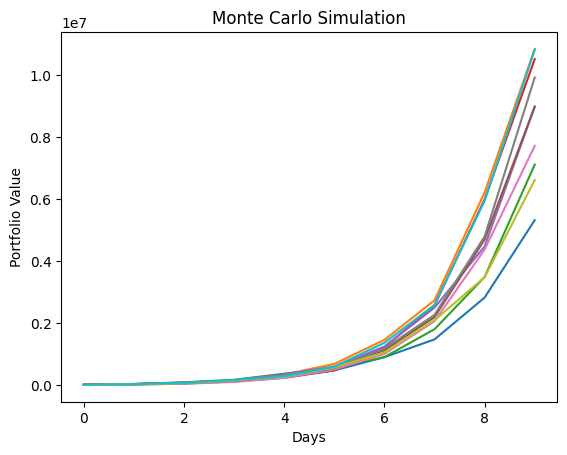

In [ ]:
# epoch = 10 #no of simulations
# time = 10 #no of days

# #initialise arrays
# mean_matrix = np.full(shape=(time, len(weights)), fill_value=meanReturns)
# mean_matrix = mean_matrix.T

# portfolio_sims = np.full(shape=(time, epoch), fill_value=0.0)
# initial_value = 10000

# for i in range(0, epoch):
#   #MC Loops
#   #Assuming daily returns are distributed by a multivariate normal distribution
#   #Cholesky Decomposition is used to determine lower triangular matrix
#   Z = np.random.normal(size=(time, len(weights)))
#   L = np.linalg.cholesky(cov_matrix)
#   dailyReturns = mean_matrix + np.inner(L, Z)
#   portfolio_sims[:,i] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initial_value

# plt.plot(portfolio_sims)
# plt.ylabel('Portfolio Value')
# plt.xlabel('Days')
# plt.title('Monte Carlo Simulation')
# plt.show()